#Code

In [1]:
%matplotlib inline

import mesa
import random
import numpy as np
import seaborn as sns

In [2]:
### GLOBALS
class Gl():
  ### structure names: junctions and edges
  J1 = "j1"
  J2 = "j2"
  J3 = "j3"
  J4 = "j4"
  E1 = "E1"
  E2 = "E2"
  E3 = "E3"
  E4 = "E4"
  E5 = "E5"
  E0 = "E0"
  E_SPAWN = "E_spawn"
  E_SPAWN_BUS = "E_spawn_bus"

  ### routes
  R14 = "R14"
  R23 = "R23"
  R153 = "R153"
  ROUTES_4LINK = [R14, R23]
  ROUTES_5LINK = [R14, R23, R153]

  ### hyperparameters
  """mostly used for the agent's memory-based strategy on choosing routes"""
  DELTA_T = 10
  PROB_INFO = 0.9
  J1_WAIT_THRESHOLD = 0.1
  J2_WAIT_THRESHOLD = 0.1


In [3]:
class Car(mesa.Agent):
  def __init__(self, unique_id, model):
    # Pass the parameters to the parent class.
    super().__init__(unique_id, model)
    self.in_pos = {"": None}  # {name of road/junction: cell position}
    self.travel_time = 0
    self.history = [] # gets appended by {route: travel_time} after destination
    self.selected_route = None
    self.expected_travel_R14 = 0
    self.expected_travel_R23 = 0
    self.expected_travel_R153 = 0
    self.waited_at_junction = 0
    self.burn_in_phase = True  # during burn-in, try each route at least once

  def move(self) -> None:
    [(name, pos)] = self.in_pos.items()
    if not name:
      raise Exception("Can't move car because it's not in any infrastructure")
    self.model.advance_agent(self)

  def update_data(self) -> None:
    self.update_travel_time()
    self.update_t_info()
    self.strat_select_route()

  def update_travel_time(self) -> None:
    if self.selected_route == None:
      # very first run, don't count it due to how agents are spawned
      return
    if self.get_structure_name() is Gl.E0:
      if self.travel_time == 0:
        # waiting in E0, do nothing
        return
      self.history.append([self.selected_route, self.travel_time])
      self.sync_travel_time_to_model()
      if len(self.history) > 30:
        # forget oldest time
        del self.history[0]
      self.travel_time = 0
    else:
      self.travel_time += 1

  def sync_travel_time_to_model(self) -> None:
    if self.selected_route == None:
      return
    if self.selected_route == Gl.R14:
      self.model.most_recent_travel_time_R14 = self.travel_time
      self.model.counter_traveled_R14 += 1
    elif self.selected_route == Gl.R23:
      self.model.most_recent_travel_time_R23 = self.travel_time
      self.model.counter_traveled_R23 += 1
    else:
      assert(self.selected_route == Gl.R153)
      self.model.most_recent_travel_time_R153 = self.travel_time
      self.model.counter_traveled_R153 += 1


  def update_t_info(self) -> None:
    if not self.get_structure_name() is Gl.E0:
      return
    counter_R14 = 0
    total_travel_time_R14 = 0
    counter_R23 = 0
    total_travel_time_R23 = 0
    counter_R153 = 0
    total_travel_time_R153 = 0
    for hist in self.history:
      route = hist[0]
      travel_time = hist[1]
      if route is Gl.R14:
        counter_R14 += 1
        total_travel_time_R14 += travel_time
      elif route is Gl.R23:
        counter_R23 += 1
        total_travel_time_R23 += travel_time
      elif route is Gl.R153:
        counter_R153 += 1
        total_travel_time_R153 += travel_time

    if counter_R14 != 0:
      self.expected_travel_R14 = total_travel_time_R14 / counter_R14
    if counter_R23 != 0:
      self.expected_travel_R23 = total_travel_time_R23 / counter_R23
    if counter_R153 != 0:
      self.expected_travel_R153 = total_travel_time_R153 / counter_R153


  def strat_select_route(self) -> None:
    """When an agent has finished its route and is on edge E0, it will select a
    route for its next round. 2 cases:
    1) burn-in phase, take each route at least once
    2) select ideal route based on memory,
    """
    if not self.get_structure_name() is Gl.E0:
      return
    # 1)
    if self.burn_in_phase:
      self.selected_route = random.choice(self.model.possible_routes())
      if len(self.history) == 30:
        self.burn_in_phase = False
    # 2)
    elif random.random() > Gl.PROB_INFO:
      self.selected_route = random.choice(self.model.possible_routes())
    elif self.expected_travel_R153 == 0:
      # 4link
      if Gl.DELTA_T < abs(self.expected_travel_R14 - self.expected_travel_R23):
        self.selected_route = self.model.possible_routes()[np.argmin([self.expected_travel_R14, self.expected_travel_R23])]
    elif (Gl.DELTA_T >= abs(self.expected_travel_R14 - self.expected_travel_R23)
        + abs(self.expected_travel_R14 - self.expected_travel_R153)
        + abs(self.expected_travel_R23 - self.expected_travel_R153)):
      # don't switch route, 5link
      return
    else:
      # switch route, 5link
      route_index = np.argmin([self.expected_travel_R14, self.expected_travel_R23,
                               self.expected_travel_R153])
      self.selected_route = self.model.possible_routes()[route_index]


  def strat_maybe_change_route(self, is4link) -> None:
    """When an agent is at a junction and the next spot on the agent's desired
    route is occupied, there's a chance that the agent will change its route"""
    assert(self.get_structure_name() is Gl.J1 or self.get_structure_name() is Gl.J2)
    self.waited_at_junction += 1
    # 4link
    if self.get_structure_name() is Gl.J1 and is4link:
      self.strat_maybe_change_route_4link()
    # 5link
    # see "Bittihn, 2018" apendix pseudocode
    elif self.get_structure_name() is Gl.J2:
      self.strat_maybe_change_route_J2()
    else:
      self.strat_maybe_change_route_J1()


  def strat_maybe_change_route_4link(self) -> None:
    if self.selected_route == Gl.R14:
      if self.expected_travel_R14 < self.expected_travel_R23:
        if self.waited_at_junction > (self.expected_travel_R23 - self.expected_travel_R14) * Gl.J2_WAIT_THRESHOLD:
          self.selected_route = Gl.R23
          self.waited_at_junction = 0
      else:
        self.selected_route = Gl.R23
        self.waited_at_junction = 0
    else:
      assert(self.selected_route == Gl.R23)
      if self.expected_travel_R23 < self.expected_travel_R14:
        if self.waited_at_junction > (self.expected_travel_R14 - self.expected_travel_R23) * Gl.J2_WAIT_THRESHOLD:
          self.selected_route = Gl.R14
          self.waited_at_junction = 0
      else:
        self.selected_route = Gl.R14
        self.waited_at_junction = 0


  def strat_maybe_change_route_J1(self) -> None: # 2 functions depending on which junction the agent is
    if self.selected_route == Gl.R14 or self.selected_route == Gl.R153:
      if self.selected_route == Gl.R14:
        if self.expected_travel_R14 < self.expected_travel_R23:
          if self.waited_at_junction > (self.expected_travel_R23 - self.expected_travel_R14) * Gl.J1_WAIT_THRESHOLD:
            self.selected_route = Gl.R23
            self.waited_at_junction = 0
        else:
          self.selected_route = Gl.R23
          self.waited_at_junction = 0
      else:
        assert(self.selected_route == Gl.R153)
        if self.expected_travel_R153 < self.expected_travel_R23:
          if self.waited_at_junction > (self.expected_travel_R23 - self.expected_travel_R153) * Gl.J1_WAIT_THRESHOLD:
            self.selected_route = Gl.R23
            self.waited_at_junction = 0
        else:
          self.selected_route = Gl.R23
          self.waited_at_junction = 0
    else:
      assert(self.selected_route == Gl.R23)
      if (self.expected_travel_R23 < self.expected_travel_R14) and (self.expected_travel_R23 < self.expected_travel_R153):
        if self.expected_travel_R14 < self.expected_travel_R153:
          if self.waited_at_junction > (self.expected_travel_R14 - self.expected_travel_R23) * Gl.J1_WAIT_THRESHOLD:
            self.selected_route = Gl.R14
            self.waited_at_junction = 0
        else:
          assert(self.expected_travel_R153 <= self.expected_travel_R14)
          if self.waited_at_junction > (self.expected_travel_R153 - self.expected_travel_R23) * Gl.J1_WAIT_THRESHOLD:
            self.selected_route = Gl.R153
            self.waited_at_junction = 0
      else:
        if self.expected_travel_R14 < self.expected_travel_R153:
          self.selected_route = Gl.R14
          self.waited_at_junction = 0
        elif self.expected_travel_R153 < self.expected_travel_R14:
          self.selected_route = Gl.R153
          self.waited_at_junction = 0
        else:
          self.selected_route = random.choice([Gl.R14, Gl.R153])
          self.waited_at_junction = 0


  def strat_maybe_change_route_J2(self) -> None:
    if self.selected_route == Gl.R14:
      if self.expected_travel_R14 < self.expected_travel_R153:
        if self.waited_at_junction > (self.expected_travel_R153 - self.expected_travel_R14) * Gl.J2_WAIT_THRESHOLD:
          self.selected_route = Gl.R153
          self.waited_at_junction = 0
      else:
        self.selected_route = Gl.R153
        self.waited_at_junction = 0
    else:
      assert(self.selected_route == Gl.R153)
      if self.expected_travel_R153 < self.expected_travel_R14:
        if self.waited_at_junction > (self.expected_travel_R14 - self.expected_travel_R153) * Gl.J2_WAIT_THRESHOLD:
          self.selected_route = Gl.R14
          self.waited_at_junction = 0
      else:
        self.selected_route = Gl.R14
        self.waited_at_junction = 0

  def get_structure_name(self):
    return next(iter(self.in_pos))

  def print_history(self) -> None:
    print(f"I'm car {self.unique_id}, my travel history: {self.history}")

  def step(self) -> None:
    self.move()
    self.update_data()
    if self.model.verbose:
      print(f"I'm car {self.unique_id} in {self.in_pos} at {self.pos}\n")

In [ ]:
class Tasep():
  """User defined class for TASEPs/edges/roads"""

  def __init__(self, L, name, pos_start, pos_end, verbose=False):
    assert L > 0
    self.length = L
    self.name = name
    self.pos_start = pos_start
    self.verbose = verbose
    self.heading = np.array(pos_end) - np.array(self.pos_start)
    self.cells = [self.default_val()] * self.length

  @staticmethod
  def default_val() -> None:
    """Default value for new cell elements."""
    return None

  @staticmethod
  def is_junction() -> bool:
    return False

  def is_cell_empty(self, id: int = 0) -> bool:
    """Returns a bool of the contents of a cell."""
    assert id >= 0 and id < self.length
    return self.cells[id] == self.default_val()

  def is_last_id(self, id: int) -> bool:
    assert id >= 0 and id < self.length
    return id == self.length - 1

  def _add_agent(self, agent: mesa.Agent, id: int) -> None:
    """Add agent at a cell id, for internal use"""
    if self.is_cell_empty(id):
      self.cells[id] = agent
      self.set_agent_pos(agent, id)
    else:
      raise Exception("Cell not empty")

  def add_agent(self, agent: mesa.Agent) -> None:
    """Add agent at the start if able"""
    self._add_agent(agent, 0)

  def advance_agent(self, agent: mesa.Agent) -> None:
    """advanced agent by 1 if able"""
    [(name, id)] = agent.in_pos.items()
    assert name is self.name

    if id == self.length - 1:
      #TODO add a way such that a car/agent goes from last place in a cell to connected junction
      raise Exception("Can't advance, agent at the last cell")
    else:
      if self.is_cell_empty(id + 1):
        self.cells[id + 1] = self.cells[id]
        self.cells[id] = self.default_val()
        self.set_agent_pos(agent, id + 1)
      elif self.verbose:
        print(f"Can't advance agent {agent.unique_id} because cell {id + 1} is not empty.")

  def set_agent_pos(self, agent: mesa.Agent, id: int):
    agent.pos = self.pos_start + id / self.length * self.heading
    agent.in_pos = {self.name: id}

  def remove_last_id(self) -> None:
    self.cells[self.length - 1] = self.default_val()
    # note, doesn't reset agent position


In [ ]:
class Junction():
  """"""

  def __init__(self, name, pos):
    self.name = name
    self.pos = pos
    self.cell = None

  @staticmethod
  def is_junction() -> bool:
    return True

  def is_cell_empty(self) -> bool:
    """Returns a bool of the content of the cell."""
    return self.cell == None

  def add_agent(self, agent: mesa.Agent) -> None:
    """Add agent if able"""
    if self.is_cell_empty():
      self.cell = agent
      agent.pos = self.pos
      agent.in_pos = {self.name: 0}
    else:
      raise Exception("Cell not empty")

  def remove_last_id(self) -> None:
    self.cell = None
    # note, doesn't reset agent position


In [ ]:
class Model_4link(mesa.Model):
  """"""

  def __init__(self, N, verbose=False):
    self.num_agents = N
    self.verbose = verbose
    self.ticks = 0
    # Create scheduler and assign it to the model
    self.schedule = mesa.time.RandomActivation(self)
    self.infrastructure = {
        Gl.J1: Junction(Gl.J1, pos=(50, 0)),
        Gl.J2: Junction(Gl.J2, pos=(0, 100)),
        Gl.J3: Junction(Gl.J3, pos=(100, 100)),
        Gl.J4: Junction(Gl.J4, pos=(50, 200)),
        Gl.E1: Tasep(100, Gl.E1, pos_start=(50, 0), pos_end=(0, 100), verbose=self.verbose),
        Gl.E2: Tasep(500, Gl.E2, pos_start=(50, 0), pos_end=(100, 100), verbose=self.verbose),
        Gl.E3: Tasep(100, Gl.E3, pos_start=(100, 100), pos_end=(50, 200), verbose=self.verbose),
        Gl.E4: Tasep(500, Gl.E4, pos_start=(0, 100), pos_end=(50, 200), verbose=self.verbose),
        # no L5 yet
        Gl.E0: Tasep(1, Gl.E0, pos_start=(120, 100), pos_end=(120, 100)),
        Gl.E_SPAWN: Tasep(self.num_agents, Gl.E_SPAWN, pos_start=(0, 0), pos_end=(0, 0), verbose=self.verbose),
    }
    self.infra_connections_R14 = {
        Gl.J1: Gl.E1,
        Gl.J2: Gl.E4,
        Gl.J4: Gl.E0,
        Gl.E1: Gl.J2,
        Gl.E4: Gl.J4,
        Gl.E0: Gl.J1,
    }
    self.infra_connections_R23 = {
        Gl.J1: Gl.E2,
        Gl.J3: Gl.E3,
        Gl.J4: Gl.E0,
        Gl.E2: Gl.J3,
        Gl.E3: Gl.J4,
        Gl.E0: Gl.J1,
    }
    self.most_recent_travel_time_R14 = None
    self.counter_traveled_R14 = 0
    self.most_recent_travel_time_R23 = None
    self.counter_traveled_R23 = 0
    self.datacollector = mesa.DataCollector(model_reporters={
        "route_R14": "most_recent_travel_time_R14",
        "route_R23": "most_recent_travel_time_R23",
        "counter_R14": "counter_traveled_R14",
        "counter_R23": "counter_traveled_R23",
    })


  @staticmethod
  def possible_routes():
    return Gl.ROUTES_4LINK


  def initialize_agents_positions(self) -> None:
    """Create agents and initialize them to the schedule and infrastructure"""
    for idx in range(self.num_agents):
      car = Car(idx, self)
      # Add the agent to the scheduler
      self.schedule.add(car)
      self.infrastructure[Gl.E_SPAWN]._add_agent(car, idx)


  def advance_agent(self, agent: mesa.Agent) -> None:
    [(infra_name, id)] = agent.in_pos.items()
    structure = self.infrastructure[infra_name]
    if structure.is_junction() or structure.is_last_id(id):
      self.advance_agent_infrastructure(agent)
    else:
      structure.advance_agent(agent)

  def advance_agent_infrastructure(self, agent: mesa.Agent) -> None:
    current_infra_name = agent.get_structure_name()
    next_infra_name = None
    match agent.selected_route:
      case Gl.R14:
        next_infra_name = self.infra_connections_R14[current_infra_name]
      case Gl.R23:
        next_infra_name = self.infra_connections_R23[current_infra_name]
      case None:
        assert(agent.travel_time == 0)
        next_infra_name = Gl.E0 # selected_route will be set in E0
      case _:
        raise Exception(f"Unknown route {agent.selected_route}")

    if self.verbose:
      print(f"try to move from {current_infra_name} to {next_infra_name}")
    elif self.infrastructure[next_infra_name].is_cell_empty():
      self.infrastructure[current_infra_name].remove_last_id()
      self.infrastructure[next_infra_name].add_agent(agent)
    else:
      if self.verbose:
        print(f"next infrastructure {next_infra_name} not empty")
      if current_infra_name is Gl.J1 or current_infra_name is Gl.J2:
        agent.strat_maybe_change_route(is4link=True)

  def collect(self) -> None:
    if self.most_recent_travel_time_R14 is not None and self.most_recent_travel_time_R23 is not None:
      self.datacollector.collect(self)

  def step(self) -> None:
    """Advance the model by one step."""
    # The model's step will go here for now this will call the step method of each agent
    self.schedule.step()
    self.collect()
    if self.verbose:
      print("----------")

In [ ]:
class Model_5link(Model_4link):
  """"""
  def __init__(self, N, verbose=False):
    super().__init__(N, verbose)
    self.infrastructure[Gl.E5] = Tasep(37, Gl.E5, pos_start=(0, 100), pos_end=(100, 100), verbose=self.verbose)
    self.infra_connections_R153 = {
        Gl.J1: Gl.E1,
        Gl.J2: Gl.E5,
        Gl.J3: Gl.E3,
        Gl.J4: Gl.E0,
        Gl.E1: Gl.J2,
        Gl.E3: Gl.J4,
        Gl.E5: Gl.J3,
        Gl.E0: Gl.J1,
    }
    self.most_recent_travel_time_R153 = None
    self.counter_traveled_R153 = 0
    self.datacollector = mesa.DataCollector(model_reporters={
        "route_R14": "most_recent_travel_time_R14",
        "route_R23": "most_recent_travel_time_R23",
        "route_R153": "most_recent_travel_time_R153",
        "counter_R14": "counter_traveled_R14",
        "counter_R23": "counter_traveled_R23",
        "counter_R153": "counter_traveled_R153",
    })


  @staticmethod
  def possible_routes():
    return Gl.ROUTES_5LINK

  # override
  def advance_agent_infrastructure(self, agent: mesa.Agent) -> None:
    current_infra_name = agent.get_structure_name()
    next_infra_name = None
    match agent.selected_route:
      case Gl.R14:
        next_infra_name = self.infra_connections_R14[current_infra_name]
      case Gl.R23:
        next_infra_name = self.infra_connections_R23[current_infra_name]
      case Gl.R153:
        next_infra_name = self.infra_connections_R153[current_infra_name]
      case None:
        assert(agent.travel_time == 0)
        next_infra_name = Gl.E0 # selected_route will be set in E0
      case _:
        raise Exception(f"Unknown route {agent.selected_route}")

    if self.verbose:
      print(f"try to move from {current_infra_name} to {next_infra_name}")
    if self.infrastructure[next_infra_name].is_cell_empty():
      self.infrastructure[current_infra_name].remove_last_id()
      self.infrastructure[next_infra_name].add_agent(agent)
    else:
      if self.verbose:
        print(f"next infrastructure {next_infra_name} not empty")
      if current_infra_name is Gl.J1 or current_infra_name is Gl.J2:
        agent.strat_maybe_change_route(is4link=False)

  # override
  def collect(self) -> None:
    if (self.most_recent_travel_time_R14 is not None and
        self.most_recent_travel_time_R23 is not None and
        self.most_recent_travel_time_R153 is not None):
      self.datacollector.collect(self)


In [ ]:
class Bus(mesa.Agent):
  def __init__(self, unique_id, model):
    # Pass the parameters to the parent class.
    super().__init__(unique_id, model)
    self.in_pos = {"": None}  # {name of road/junction: cell position}
    self.travel_time = 0
    self.selected_route = Gl.R153

  def move(self) -> None:
    [(name, pos)] = self.in_pos.items()
    if not name:
      raise Exception("Can't move car because it's not in any infrastructure")
    self.model.advance_agent(self) # does this work?

  def update_data(self) -> None:
    self.update_travel_time()

  def update_travel_time(self) -> None:
    if self.get_structure_name() is Gl.E0:
      if self.travel_time == 0:
        # waiting in E0, do nothing
        return
      self.sync_travel_time_to_model()
      self.travel_time = 0
    else:
      self.travel_time += 1

  def sync_travel_time_to_model(self) -> None:
    assert(self.selected_route == Gl.R153)
    self.model.most_recent_travel_time_R153 = self.travel_time
    self.model.counter_traveled_R153 += 1

  def get_structure_name(self):
    return next(iter(self.in_pos))

  def print_history(self) -> None:
    print(f"I'm bus {self.unique_id}, I have no history")

  def strat_maybe_change_route(self, is4link) -> None:
    # busses do not change route
    pass

  def step(self) -> None:
    self.move()
    self.update_data()
    if self.model.verbose:
      print(f"I'm bus {self.unique_id} in {self.in_pos} at {self.pos}\n")

In [ ]:
class Model_5link_with_bus(Model_5link):
  """"""
  def __init__(self, n_car, n_bus, verbose=False):
    super().__init__(n_car, verbose)
    self.n_car = n_car  # number of cars
    self.n_bus = n_bus  # number of busses
    # add spawn edge for busses
    self.infrastructure[Gl.E_SPAWN_BUS] = Tasep(self.n_bus, Gl.E_SPAWN_BUS, pos_start=(0, 0), pos_end=(0, 0), verbose=self.verbose)
    self.infra_connections_R153[Gl.E_SPAWN_BUS] = Gl.E0

  @staticmethod
  def possible_routes(isBus=False):
    if isBus:
      return [Gl.R153]
    #else
    return Gl.ROUTES_4LINK

  #overide
  def initialize_agents_positions(self) -> None:
    """Create car and bus agents and initialize them to the schedule and infrastructure"""
    super().initialize_agents_positions()
    for idx in range(self.n_bus):
      bus = Bus(self.n_car + idx, self)
      self.schedule.add(bus)
      self.infrastructure[Gl.E_SPAWN_BUS]._add_agent(bus, idx)

  # unfortunate to have to copy this all, could maybe improve? (is4link=True)
  # override
  def advance_agent_infrastructure(self, agent: mesa.Agent) -> None:
    current_infra_name = agent.get_structure_name()
    next_infra_name = None
    match agent.selected_route:
      case Gl.R14:
        next_infra_name = self.infra_connections_R14[current_infra_name]
      case Gl.R23:
        next_infra_name = self.infra_connections_R23[current_infra_name]
      case Gl.R153:
        next_infra_name = self.infra_connections_R153[current_infra_name]
      case None:
        assert(agent.travel_time == 0)
        next_infra_name = Gl.E0 # selected_route will be set in E0
      case _:
        raise Exception(f"Unknown route {agent.selected_route}")

    if self.verbose:
      print(f"try to move from {current_infra_name} to {next_infra_name}")
    if self.infrastructure[next_infra_name].is_cell_empty():
      self.infrastructure[current_infra_name].remove_last_id()
      self.infrastructure[next_infra_name].add_agent(agent)
    else:
      if self.verbose:
        print(f"next infrastructure {next_infra_name} not empty")
      if current_infra_name is Gl.J1 or current_infra_name is Gl.J2:
        agent.strat_maybe_change_route(is4link=True) # cars may only use 4link
        # busses don't switch at all

In [ ]:
class Car_toll(Car):
  def __init__(self, unique_id, model):
    # Pass the parameters to the parent class.
    super().__init__(unique_id, model)
    self.cost_sensitivity = 1
    self.toll_cost = self.model.base_toll_cost * self.cost_sensitivity

  #override
  def update_travel_time(self) -> None:
    if self.selected_route == None:
      # very first run, don't count it due to how agents are spawned
      return
    if self.get_structure_name() is Gl.E0:
      if self.travel_time == 0:
        # waiting in E0, do nothing
        return
      if self.selected_route == Gl.R153:
        self.history.append([self.selected_route, self.travel_time + self.toll_cost])
      else:
        self.history.append([self.selected_route, self.travel_time])
      self.sync_travel_time_to_model()
      if len(self.history) > 30:
        # forget oldest time
        del self.history[0]
      self.travel_time = 0
    else:
      self.travel_time += 1

  #override
  def sync_travel_time_to_model(self) -> None:
    if self.selected_route == None:
      return
    if self.selected_route == Gl.R14:
      self.model.most_recent_travel_time_R14 = self.travel_time
      self.model.counter_traveled_R14 += 1
    elif self.selected_route == Gl.R23:
      self.model.most_recent_travel_time_R23 = self.travel_time
      self.model.counter_traveled_R23 += 1
    else:
      assert(self.selected_route == Gl.R153)
      self.model.most_recent_travel_time_R153 = self.travel_time
      self.model.experienced_travel_time_R153 = self.travel_time + self.toll_cost
      self.model.counter_traveled_R153 += 1


In [ ]:
class Model_5link_toll(Model_5link):
  """"""
  def __init__(self, N, base_toll_cost, verbose=False):
    super().__init__(N, verbose)
    self.base_toll_cost = base_toll_cost
    self.experienced_travel_time_R153 = None
    self.datacollector = mesa.DataCollector(model_reporters={
        "route_R14": "most_recent_travel_time_R14",
        "route_R23": "most_recent_travel_time_R23",
        "route_R153": "most_recent_travel_time_R153",
        "counter_R14": "counter_traveled_R14",
        "counter_R23": "counter_traveled_R23",
        "counter_R153": "counter_traveled_R153",
        "experienced_R153": "experienced_travel_time_R153"
    })

  #override
  def initialize_agents_positions(self) -> None:
    """Create agents and initialize them to the schedule and infrastructure"""
    for idx in range(self.num_agents):
      car = Car_toll(idx, self)
      # Add the agent to the scheduler
      self.schedule.add(car)
      self.infrastructure[Gl.E_SPAWN]._add_agent(car, idx)

# 5link

In [ ]:
my_model = Model_5link(248, verbose=False)
my_model.initialize_agents_positions()

In [ ]:
for idx in range(200000):
  my_model.step()

In [ ]:
#sns.set_theme(rc={'figure.dpi': 150, 'figure.figsize': (5, 3.75)})
#sns.reset_defaults()

%config InlineBackend.figure_formats = ['svg']          # try 1

#from IPython.display import set_matplotlib_formats     # try 2, for if 1 doesn't work
#set_matplotlib_formats('svg')

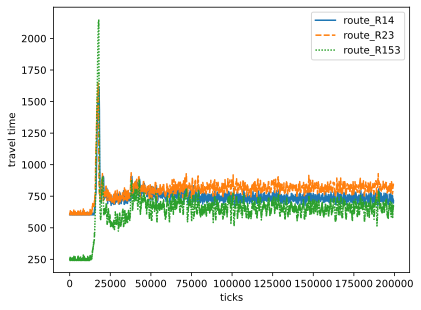

In [ ]:
model_data_5link = my_model.datacollector.get_model_vars_dataframe()

g = sns.lineplot(data=model_data_5link.iloc[:, 0:3])
g.set(title="", ylabel="travel time", xlabel="ticks"); # most recent travel time per route 5link

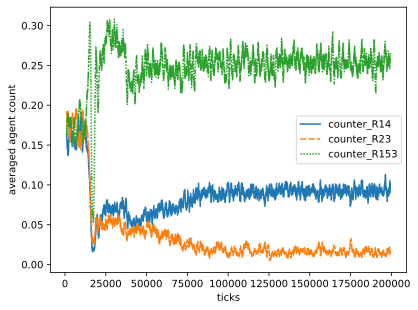

In [ ]:
model_diff_5link = model_data_5link.iloc[:, 3:].diff()
model_counts_5link = model_diff_5link.rolling(window=1000).mean()

h = sns.lineplot(data=model_counts_5link)
h.set(title="", ylabel="averaged agent count", xlabel="ticks"); # agent taking which route 5link

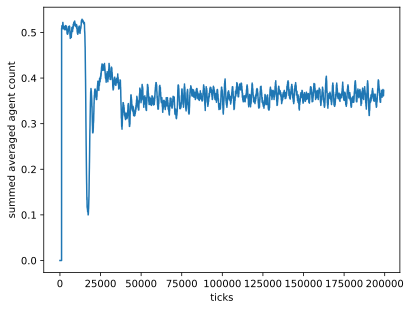

In [ ]:
i = sns.lineplot(data=model_counts_5link.sum(axis=1))
i.set(title="", ylabel="summed averaged agent count", xlabel="ticks"); # network flow 5link

#4link

In [ ]:
model_4link = Model_4link(248, verbose=False)
model_4link.initialize_agents_positions()

for idx in range(200000):
  model_4link.step()

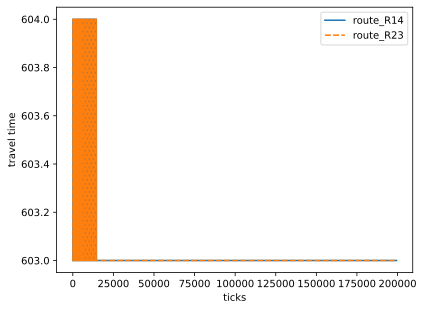

In [ ]:
model_data_4link = model_4link.datacollector.get_model_vars_dataframe()

g_4 = sns.lineplot(data=model_data_4link.iloc[:, 0:2])
g_4.set(title="", ylabel="travel time", xlabel="ticks"); # most recent travel time per route 4link

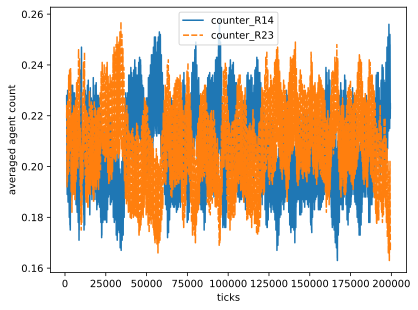

In [ ]:
model_diff_4link = model_data_4link.iloc[:, 2:].diff()
model_counts_4link = model_diff_4link.rolling(window=1000).mean()

h_4 = sns.lineplot(data=model_counts_4link)
h_4.set(title="", ylabel="averaged agent count", xlabel="ticks"); # agent taking which route 4link

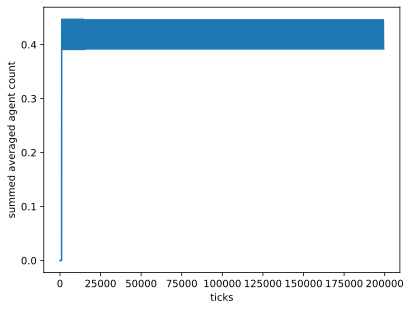

In [ ]:
i_4 = sns.lineplot(data=model_counts_4link.sum(axis=1))
i_4.set(title="", ylabel="summed averaged agent count", xlabel="ticks"); # network flow 4link

In [ ]:
print(f"mean flow 4link {model_counts_4link.iloc[100000 :, :].sum(axis=1).mean()}")
print(f"mean flow 5link {model_counts_5link.iloc[100000 :, :].sum(axis=1).mean()}")

# output:
### mean flow 4link 0.41063799903412757
### mean flow 5link 0.3615990180691376
#
# note that 4 link flow is higher. So the "global" time of 4 link is faster when compared to 5 link (Braess' paradox!)

mean flow 4link 0.41063799903412757
mean flow 5link 0.3617514691084725


# Now 5link with both cars and busses

## 228 cars, 20 busses

In [ ]:
mixed_car_bus_model = Model_5link_with_bus(228, 20, verbose=False)
mixed_car_bus_model.initialize_agents_positions()

for idx in range(0, 200000):
  mixed_car_bus_model.step()


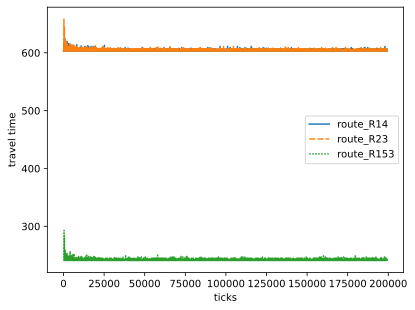

In [ ]:
model_data_5link_with_bus = mixed_car_bus_model.datacollector.get_model_vars_dataframe()

g_5b = sns.lineplot(data=model_data_5link_with_bus.iloc[:, 0:3])
g_5b.set(title="", ylabel="travel time", xlabel="ticks"); # most recent travel time per route 5linkbus

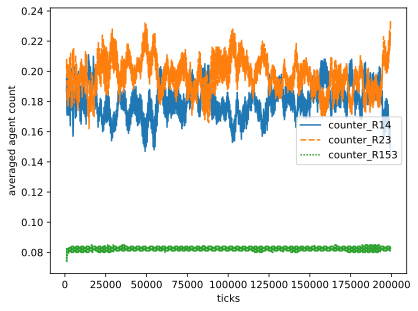

In [ ]:
model_diff_5link_with_bus = model_data_5link_with_bus.iloc[:, 3:].diff()
model_counts_5link_with_bus = model_diff_5link_with_bus.rolling(window=1000).mean()

h_5b = sns.lineplot(data=model_counts_5link_with_bus)
h_5b.set(title="", ylabel="averaged agent count", xlabel="ticks"); # agent taking which route 5linkbus

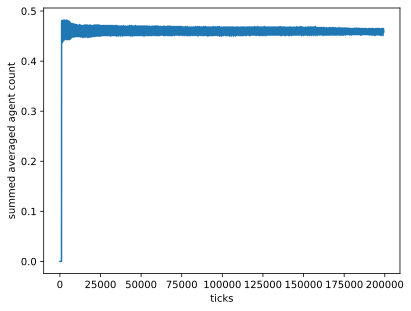

In [ ]:
i_5b = sns.lineplot(data=model_counts_5link_with_bus.sum(axis=1))
i_5b.set(title="", ylabel="summed averaged agent count", xlabel="ticks"); # network flow 5linkbus

In [ ]:
print(f"mean flow 5link with busses {model_counts_5link_with_bus.iloc[100000 :, :].sum(axis=1).mean()}")

# output:
### mean flow 5link with busses 0.4594946015838038

mean flow 5link with busses 0.45955931742949424


In [ ]:
print(f"mean after 100,000 ticks route R14 {model_data_5link_with_bus.route_R14[100000 :].mean()}")
print(f"mean after 100,000 ticks route R23 {model_data_5link_with_bus.route_R23[100000 :].mean()}")
print(f"mean after 100,000 ticks route R153 (busses) {model_data_5link_with_bus.route_R153[100000 :].mean()}")

mean after 100,000 ticks route R14 603.3339705601223
mean after 100,000 ticks route R23 603.3955970982704
mean after 100,000 ticks route R153 (busses) 241.75120989244283


In [ ]:
test1 = model_data_5link_with_bus.route_R14[100000 :].mean() * (model_data_5link_with_bus.counter_R14.iloc[-1] - model_data_5link_with_bus.counter_R14[100000])
test2 = model_data_5link_with_bus.route_R23[100000 :].mean() * (model_data_5link_with_bus.counter_R23.iloc[-1] - model_data_5link_with_bus.counter_R23[100000])
test3 = model_data_5link_with_bus.route_R153[100000 :].mean() * (model_data_5link_with_bus.counter_R153.iloc[-1] - model_data_5link_with_bus.counter_R153[100000])

(test1 + test2 + test3) / (model_data_5link_with_bus.iloc[-1, [3, 4, 5]].sum() - model_data_5link_with_bus.iloc[100000, [3, 4, 5]].sum()) #average cost-included-travel time whole system after 100000 ticks

538.5512953731554

## parameter sweep ratio cars-busses

In [ ]:
total_n_vehicles = 248
n_busses_min = 10
n_busses_max = 110
n_busses_step = 20

bus_models = []
for n_bus in range(n_busses_min, n_busses_max, n_busses_step):
  n_car = total_n_vehicles - n_bus
  model = Model_5link_with_bus(n_car, n_bus)
  model.initialize_agents_positions()
  bus_models.append(model)

for model in bus_models:
  for idx in range(150000):
    model.step()


In [ ]:
"""
A measure for how well the system works. Gives the average time it takes for an agent to complete one round.
Takes as input a dataframe. !Assumes the names of the variables in the dataframe!
Works with the mixed-bus-car-model, but not with the toll-cost-model
"""
def average_travel_time_across_all_routes_and_agents(dataframe):
  routeR14 = dataframe.route_R14[100000 :].mean() * (dataframe.counter_R14.iloc[-1] - dataframe.counter_R14[100000])
  routeR23 = dataframe.route_R23[100000 :].mean() * (dataframe.counter_R23.iloc[-1] - dataframe.counter_R23[100000])
  routeR153 = dataframe.route_R153[100000 :].mean() * (dataframe.counter_R153.iloc[-1] - dataframe.counter_R153[100000])

  return (routeR14 + routeR23 + routeR153) / (dataframe.iloc[-1, [3, 4, 5]].sum() - dataframe.iloc[100000, [3, 4, 5]].sum())

In [ ]:
bus_models_dataframes = []

for model in bus_models:
  df = model.datacollector.get_model_vars_dataframe()
  bus_models_dataframes.append(df)
  print(f"Model with {model.n_bus} busses: average travel time of {average_travel_time_across_all_routes_and_agents(df)}")

# output
### Model with 10 busses: average travel time of 569.1177193227004
### Model with 30 busses: average travel time of 511.60995584326
### Model with 50 busses: average travel time of 472.3425274527742
### Model with 70 busses: average travel time of 481.6631990762696
### Model with 90 busses: average travel time of 485.35962842440443

Model with 10 busses: average travel time of 569.1608818434944
Model with 30 busses: average travel time of 511.6131075732571
Model with 50 busses: average travel time of 471.94684772066086
Model with 70 busses: average travel time of 480.39818258571455
Model with 90 busses: average travel time of 484.9643363067267


#Toll cost on E5

## toll base cost 360

In [ ]:
model_5link_toll = Model_5link_toll(248, base_toll_cost=360)
model_5link_toll.initialize_agents_positions()

for idx in range(200000):
  model_5link_toll.step()

[Text(0.5, 1.0, ''), Text(0, 0.5, 'travel time'), Text(0.5, 0, 'ticks')]

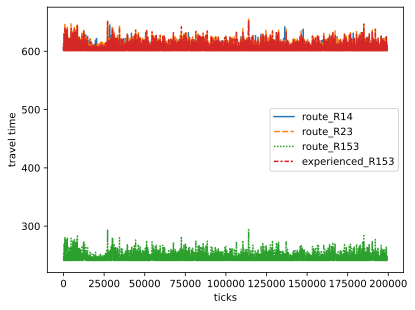

In [ ]:
model_toll_df = model_5link_toll.datacollector.get_model_vars_dataframe()

g_5t = sns.lineplot(data=model_toll_df.iloc[:, [0, 1, 2, 6]])
g_5t.set(title="", ylabel="travel time", xlabel="ticks") # most recent travel time per route 5linktoll


[Text(0.5, 1.0, ''),
 Text(0, 0.5, 'averaged agent count'),
 Text(0.5, 0, 'ticks')]

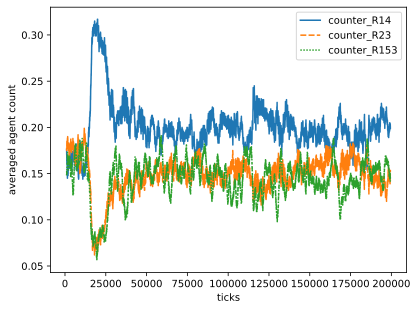

In [ ]:
model_diff_toll_df = model_toll_df.iloc[:, [3, 4, 5]].diff()
model_counts_toll_df = model_diff_toll_df.rolling(window=1000).mean()

h_5t = sns.lineplot(data=model_counts_toll_df)
h_5t.set(title="", ylabel="averaged agent count", xlabel="ticks") # agent taking which route 5linktoll

[Text(0.5, 1.0, ''),
 Text(0, 0.5, 'summed averaged agent count'),
 Text(0.5, 0, 'ticks')]

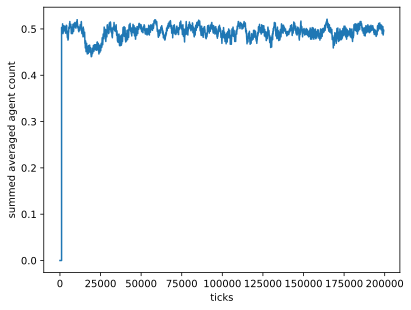

In [ ]:
i_5t = sns.lineplot(data=model_counts_toll_df.sum(axis=1))
i_5t.set(title="", ylabel="summed averaged agent count", xlabel="ticks") # network flow 5linktoll

In [ ]:
print(f"mean after 100,000 ticks route R14 {model_toll_df.route_R14[100000 :].mean()}")
print(f"mean after 100,000 ticks route R23 {model_toll_df.route_R23[100000 :].mean()}")
print(f"mean after 100,000 ticks route R153 {model_toll_df.route_R153[100000 :].mean()}")
print(f"mean after 100,000 ticks route toll-cost-included R153 {model_toll_df.experienced_R153[100000 :].mean()}")

mean after 100,000 ticks route R14 605.3140519982292
mean after 100,000 ticks route R23 607.4731255282328
mean after 100,000 ticks route R153 245.64870004427092
mean after 100,000 ticks route toll-cost-included R153 605.648700044271


In [ ]:
test1 = model_toll_df.route_R14[100000 :].mean() * (model_toll_df.counter_R14.iloc[-1] - model_toll_df.counter_R14[100000])
test2 = model_toll_df.route_R23[100000 :].mean() * (model_toll_df.counter_R23.iloc[-1] - model_toll_df.counter_R23[100000])
test3 = model_toll_df.experienced_R153[100000 :].mean() * (model_toll_df.counter_R153.iloc[-1] - model_toll_df.counter_R153[100000])

(test1 + test2 + test3) / (model_toll_df.iloc[-1, [3, 4, 5]].sum() - model_toll_df.iloc[100000, [3, 4, 5]].sum()) #average cost-included-travel time whole system after 100000 ticks

606.0770368774378

# save dataframes

In [ ]:
#"""
from google.colab import drive
drive.mount('/content/drive')
#"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#"""
model_data_4link.to_csv('/content/drive/My Drive/DoMAS/data_4link.csv', index=False)
model_data_5link.to_csv('/content/drive/My Drive/DoMAS/data_5link.csv', index=False)
model_data_5link_with_bus.to_csv('/content/drive/My Drive/DoMAS/data_5link_with_bus_20.csv', index=False) # hardcoded 20 busses, CHECK THIS
model_toll_df.to_csv('/content/drive/My Drive/DoMAS/data_5link_toll.csv', index=False) # hardcoded toll cost 360, CHECK THIS

n_bus = 10       # hardcoded
for df in bus_models_dataframes:
  df.to_csv(f'/content/drive/My Drive/DoMAS/data_5link_bus_{n_bus}.csv', index=False)
  n_bus += 20    # hardcoded
#"""

#visualization

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# inspiration from https://github.com/projectmesa/mesa-examples/blob/main/examples/boid_flockers/Flocker%20Test.ipynb

def draw_agents(model):
  coords_x = []
  coords_y = []
  for agent in model.schedule.agents:
    x, y = agent.pos
    coords_x.append(x)
    coords_y.append(y)
  fig = plt.figure(figsize=(5, 5))
  fig.text(x=0.15, y=0.15, s=f"ticks: {model.schedule.time}")
  ax = fig.add_subplot(111)
  ax.scatter(coords_x, coords_y)


In [ ]:
vis_model = Model_4link(300)
vis_model.initialize_agents_positions()

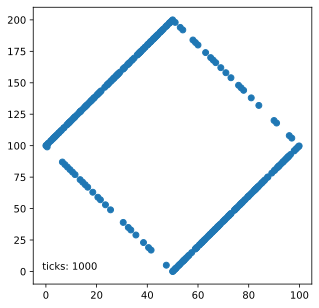

In [ ]:
# run this cell multiple times and see a new plot 1000 ticks/steps ahead on each run

for _ in range(1000):
  vis_model.step()
draw_agents(vis_model)

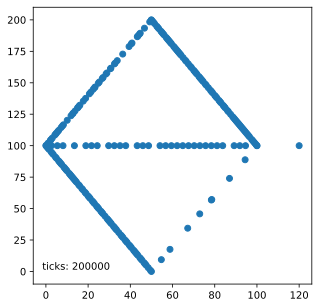

In [ ]:
draw_agents(my_model)

#prototype / Legacy

In [ ]:
class car(mesa.Agent):
  def __init__(self, unique_id, model):
    # Pass the parameters to the parent class.
    super().__init__(unique_id, model)

  def move(self):
    next_position = (self.pos[0] + 1, self.pos[1])
    if(next_position[0]>19): #this should be better, but if out of range of the array something should happen
      return
    if self.model.grid.is_cell_empty(next_position):
      self.model.grid.move_agent(self, next_position)
    else:
        print("next place full, dont move")
    print(self.pos)

  def step(self):
    self.move()


In [ ]:
class PrototypeModel(mesa.Model):
    """A prototype, just to get something working as a start"""

    def __init__(self, N):
        self.num_agents = N
        # Create scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)
        # Simplification, one road as a 1 height SingleGrid
        self.grid = mesa.space.SingleGrid(20, 1, False)

        # Create agents
        for i in range(self.num_agents):
            a = car(i, self)
            # Add the agent to the scheduler
            self.schedule.add(a)
            while True:
              x = self.random.randrange(self.grid.width)
              try:
                self.grid.place_agent(a, (x, 0))
                break;
              except:
                print("place taken, trying again")

    def step(self):
        """Advance the model by one step."""

        # The model's step will go here for now this will call the step method of each agent and print the agent's unique_id
        self.schedule.step()

In [ ]:
prototype_model = PrototypeModel(5)
for i in range(0,50):
  prototype_model.step()

place taken, trying again
next place full, dont move
(1, 0)
(3, 0)
(13, 0)
(9, 0)
(4, 0)
(14, 0)
(10, 0)
(2, 0)
(11, 0)
(5, 0)
(3, 0)
(15, 0)
(6, 0)
(12, 0)
(16, 0)
(4, 0)
(7, 0)
(5, 0)
(17, 0)
(13, 0)
(8, 0)
(14, 0)
(6, 0)
(18, 0)
(9, 0)
(7, 0)
next place full, dont move
(18, 0)
(15, 0)
next place full, dont move
(18, 0)
(16, 0)
(8, 0)
(10, 0)
(17, 0)
(9, 0)
next place full, dont move
(18, 0)
(11, 0)
next place full, dont move
(18, 0)
(10, 0)
next place full, dont move
(17, 0)
(12, 0)
(11, 0)
next place full, dont move
(17, 0)
next place full, dont move
(18, 0)
(13, 0)
next place full, dont move
(17, 0)
(12, 0)
next place full, dont move
(18, 0)
(14, 0)
next place full, dont move
(17, 0)
(15, 0)
next place full, dont move
(18, 0)
(13, 0)
(14, 0)
next place full, dont move
(17, 0)
(16, 0)
next place full, dont move
(18, 0)
next place full, dont move
(17, 0)
next place full, dont move
(18, 0)
next place full, dont move
(16, 0)
(15, 0)
next place full, dont move
(18, 0)
next place full, 

## **Legacy/old code: Trying visualization**

In [ ]:
from mesa.datacollection import DataCollector

def compute_dummy_data(model):
    return random.randint(0, 100)

class PrototypeModel2(mesa.Model):
    """A prototype, just to get something working as a start"""

    def __init__(self, N):
        self.num_agents = N
        # Create scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)
        # Simplification, one road as a 1 height SingleGrid
        self.grid = mesa.space.SingleGrid(20, 1, False)

        # Create agents
        for i in range(self.num_agents):
            a = car(i, self)
            # Add the agent to the scheduler
            self.schedule.add(a)
            self.grid.place_agent(a, (i, 0))

        ar = {"id": lambda a: a.unique_id}
        self.datacollector = DataCollector(model_reporters={"dummy": compute_dummy_data}, agent_reporters=ar)
        self.running = True

    def step(self):
        """Advance the model by one step."""

        # The model's step will go here for now this will call the step method of each agent and print the agent's unique_id
        self.schedule.step()

        self.datacollector.collect(self)

    def run_model(self, steps):
        for i in range(steps):
          self.step()

In [ ]:
model_params = {
    "N": {
        "type": "SliderInt",
        "value": 20,
        "label": "Number of agents:",
        "min": 1,
        "max": 20,
        "step": 1,
    },
}

In [ ]:
from mesa.experimental import JupyterViz

def agent_portrayal(agent):
    return {
        "color": "tab:blue",
        "size": 50,
    }

page = JupyterViz(
    PrototypeModel2,
    model_params,
    measures=["dummy"],
    name="Protoype",
    agent_portrayal=agent_portrayal,
)
# This is required to render the visualization in the Jupyter notebook
page

Html(layout=None, style_='display: none', tag='span')

Cannot show ipywidgets in text